# Essential Dataset - Baseline Models

이 노트북에서는 Essential 데이터셋을 사용하여 베이스라인 예측 모델을 개발합니다.

## 모델링 접근법
- **사망 예측**: Logistic Regression
- **입원기간 예측**: Linear Regression
- **검증 방법**: 시간 기반 분할 (70:30, 과거:최근)

## 평가 지표
- **사망 예측**: AUROC, F1 Score, Precision, Recall
- **입원기간 예측**: MAE, RMSE, R²

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 모델링 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

# 시각화 설정
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로딩

In [2]:
# Essential 데이터셋 로딩
df = pd.read_csv('../../../data/essential/model_dataset_essential.csv')

print("데이터셋 크기:", df.shape)
print("\n컬럼 목록:")
print(df.columns.tolist())

데이터셋 크기: (1200, 23)

컬럼 목록:
['hadm_id', 'subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'death_type', 'death_binary', 'hospital_death', 'los_hours', 'los_days', 'age', 'gender', 'admission_type', 'Hematocrit_51221_merged', 'Hemoglobin_51222', 'Creatinine_50912_merged', 'RDW_51277', 'White_Blood_Cells_51301_merged', 'Urea_Nitrogen_51006_merged', 'Potassium_50971_merged', 'Sodium_50983_merged', 'Glucose_50931']


In [3]:
# 타겟 변수 분포 확인
print("=" * 50)
print("타겟 변수 분포")
print("=" * 50)

print("\n1. 사망 유형 (death_type):")
print(df['death_type'].value_counts())
print("\n2. 이진 사망 (death_binary):")
print(df['death_binary'].value_counts())
print("비율:", df['death_binary'].mean())

print("\n3. 병원 내 사망 (hospital_death):")
print(df['hospital_death'].value_counts())
print("비율:", df['hospital_death'].mean())

print("\n4. 입원기간 (los_days):")
print(df['los_days'].describe())

타겟 변수 분포

1. 사망 유형 (death_type):
death_type
alive       600
outside     300
hospital    300
Name: count, dtype: int64

2. 이진 사망 (death_binary):
death_binary
0    600
1    600
Name: count, dtype: int64
비율: 0.5

3. 병원 내 사망 (hospital_death):
hospital_death
0    900
1    300
Name: count, dtype: int64
비율: 0.25

4. 입원기간 (los_days):
count    1200.000000
mean        6.389216
std        10.480003
min         0.000000
25%         1.451389
50%         3.552778
75%         7.007465
max       157.838194
Name: los_days, dtype: float64


## 2. 시간 기반 데이터 분할

입원 시간(admittime)을 기준으로 과거 70%, 최근 30%로 분할합니다.

In [4]:
# admittime을 datetime으로 변환
df['admittime'] = pd.to_datetime(df['admittime'])

# 시간순 정렬
df = df.sort_values('admittime').reset_index(drop=True)

# 70:30 분할 지점 찾기
split_idx = int(len(df) * 0.7)
split_date = df.iloc[split_idx]['admittime']

print(f"전체 데이터: {len(df)}건")
print(f"분할 인덱스: {split_idx}")
print(f"분할 날짜: {split_date}")
print(f"\n데이터 기간:")
print(f"  - 전체: {df['admittime'].min()} ~ {df['admittime'].max()}")
print(f"  - 훈련(70%): {df['admittime'].min()} ~ {split_date}")
print(f"  - 검증(30%): {split_date} ~ {df['admittime'].max()}")

전체 데이터: 1200건
분할 인덱스: 840
분할 날짜: 2170-06-21 16:35:00

데이터 기간:
  - 전체: 2110-02-06 19:39:00 ~ 2208-07-30 12:30:00
  - 훈련(70%): 2110-02-06 19:39:00 ~ 2170-06-21 16:35:00
  - 검증(30%): 2170-06-21 16:35:00 ~ 2208-07-30 12:30:00


In [10]:
# 훈련/검증 데이터 분할
train_df = df[df['admittime'] < split_date].copy()
test_df = df[df['admittime'] >= split_date].copy()

print(f"훈련 데이터: {len(train_df)}건 ({len(train_df)/len(df)*100:.1f}%)")
print(f"검증 데이터: {len(test_df)}건 ({len(test_df)/len(df)*100:.1f}%)")

# 타겟 분포 확인
print("\n훈련 데이터 타겟 분포:")
print(f"  - death_binary: {train_df['death_binary'].mean():.3f}")
print(f"  - hospital_death: {train_df['hospital_death'].mean():.3f}")
print(f"  - los_days 평균: {train_df['los_days'].mean():.2f}")

print("\n검증 데이터 타겟 분포:")
print(f"  - death_binary: {test_df['death_binary'].mean():.3f}")
print(f"  - hospital_death: {test_df['hospital_death'].mean():.3f}")
print(f"  - los_days 평균: {test_df['los_days'].mean():.2f}")

훈련 데이터: 840건 (70.0%)
검증 데이터: 360건 (30.0%)

훈련 데이터 타겟 분포:
  - death_binary: 0.500
  - hospital_death: 0.255
  - los_days 평균: 6.33

검증 데이터 타겟 분포:
  - death_binary: 0.500
  - hospital_death: 0.239
  - los_days 평균: 6.53


## 3. 특성 전처리

In [11]:
# 특성과 타겟 분리를 위한 컬럼 정의
id_cols = ['hadm_id', 'subject_id']
target_cols = ['death_type', 'death_binary', 'hospital_death', 'los_hours', 'los_days']
time_cols = ['admittime', 'dischtime', 'deathtime', 'dod']

# 특성 컬럼 선택
feature_cols = [col for col in df.columns 
                if col not in id_cols + target_cols + time_cols]

print(f"특성 개수: {len(feature_cols)}")
print(f"특성 목록: {feature_cols}")

특성 개수: 12
특성 목록: ['age', 'gender', 'admission_type', 'Hematocrit_51221_merged', 'Hemoglobin_51222', 'Creatinine_50912_merged', 'RDW_51277', 'White_Blood_Cells_51301_merged', 'Urea_Nitrogen_51006_merged', 'Potassium_50971_merged', 'Sodium_50983_merged', 'Glucose_50931']


In [12]:
# 범주형 변수 처리 (gender, admission_type)
# One-hot encoding
train_df_encoded = pd.get_dummies(train_df[feature_cols], 
                                  columns=['gender', 'admission_type'],
                                  drop_first=True)
test_df_encoded = pd.get_dummies(test_df[feature_cols], 
                                 columns=['gender', 'admission_type'],
                                 drop_first=True)

# 컬럼 일치 확인 및 조정
# 훈련 데이터에 있지만 테스트에 없는 컬럼 추가
for col in train_df_encoded.columns:
    if col not in test_df_encoded.columns:
        test_df_encoded[col] = 0

# 테스트 데이터에 있지만 훈련에 없는 컬럼 제거
test_df_encoded = test_df_encoded[train_df_encoded.columns]

print(f"인코딩 후 특성 개수: {train_df_encoded.shape[1]}")
print(f"훈련 데이터 shape: {train_df_encoded.shape}")
print(f"검증 데이터 shape: {test_df_encoded.shape}")

인코딩 후 특성 개수: 19
훈련 데이터 shape: (840, 19)
검증 데이터 shape: (360, 19)


In [13]:
# 결측값 처리 - 중앙값으로 대체
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(train_df_encoded)
X_test = imputer.transform(test_df_encoded)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"최종 훈련 데이터: {X_train_scaled.shape}")
print(f"최종 검증 데이터: {X_test_scaled.shape}")

최종 훈련 데이터: (840, 19)
최종 검증 데이터: (360, 19)


## 4. 사망 예측 모델 (Logistic Regression)

### 4.1 전체 사망 예측 (death_binary)

In [14]:
# 타겟 변수 준비
y_train_death = train_df['death_binary'].values
y_test_death = test_df['death_binary'].values

# Logistic Regression 모델 학습
lr_death = LogisticRegression(random_state=42, max_iter=1000)
lr_death.fit(X_train_scaled, y_train_death)

# 예측
y_pred_death = lr_death.predict(X_test_scaled)
y_pred_proba_death = lr_death.predict_proba(X_test_scaled)[:, 1]

# 평가
print("=" * 50)
print("전체 사망 예측 결과 (death_binary)")
print("=" * 50)
print(f"AUROC: {roc_auc_score(y_test_death, y_pred_proba_death):.4f}")
print(f"F1 Score: {f1_score(y_test_death, y_pred_death):.4f}")
print(f"Precision: {precision_score(y_test_death, y_pred_death):.4f}")
print(f"Recall: {recall_score(y_test_death, y_pred_death):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_death, y_pred_death)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_death, y_pred_death, 
                           target_names=['생존', '사망']))

전체 사망 예측 결과 (death_binary)
AUROC: 0.7794
F1 Score: 0.7318
Precision: 0.7360
Recall: 0.7278

Confusion Matrix:
[[133  47]
 [ 49 131]]

Classification Report:
              precision    recall  f1-score   support

          생존       0.73      0.74      0.73       180
          사망       0.74      0.73      0.73       180

    accuracy                           0.73       360
   macro avg       0.73      0.73      0.73       360
weighted avg       0.73      0.73      0.73       360



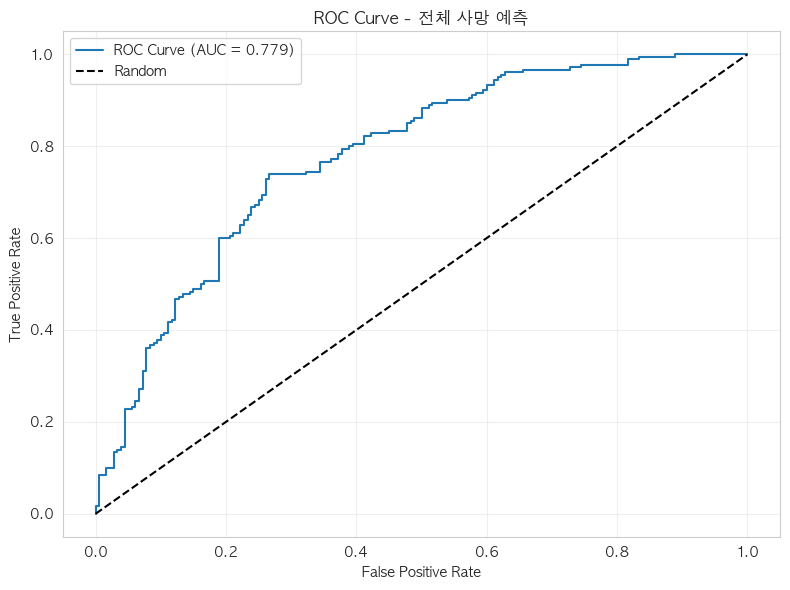

In [15]:
# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_test_death, y_pred_proba_death)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_death, y_pred_proba_death):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 전체 사망 예측')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_roc_death.png', dpi=100, bbox_inches='tight')
plt.show()

### 4.2 병원 내 사망 예측 (hospital_death)

In [16]:
# 타겟 변수 준비
y_train_hosp = train_df['hospital_death'].values
y_test_hosp = test_df['hospital_death'].values

# Logistic Regression 모델 학습
lr_hosp = LogisticRegression(random_state=42, max_iter=1000)
lr_hosp.fit(X_train_scaled, y_train_hosp)

# 예측
y_pred_hosp = lr_hosp.predict(X_test_scaled)
y_pred_proba_hosp = lr_hosp.predict_proba(X_test_scaled)[:, 1]

# 평가
print("=" * 50)
print("병원 내 사망 예측 결과 (hospital_death)")
print("=" * 50)
print(f"AUROC: {roc_auc_score(y_test_hosp, y_pred_proba_hosp):.4f}")
print(f"F1 Score: {f1_score(y_test_hosp, y_pred_hosp):.4f}")
print(f"Precision: {precision_score(y_test_hosp, y_pred_hosp):.4f}")
print(f"Recall: {recall_score(y_test_hosp, y_pred_hosp):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_hosp, y_pred_hosp)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_hosp, y_pred_hosp, 
                           target_names=['생존', '병원내사망']))

병원 내 사망 예측 결과 (hospital_death)
AUROC: 0.8011
F1 Score: 0.4681
Precision: 0.6000
Recall: 0.3837

Confusion Matrix:
[[252  22]
 [ 53  33]]

Classification Report:
              precision    recall  f1-score   support

          생존       0.83      0.92      0.87       274
       병원내사망       0.60      0.38      0.47        86

    accuracy                           0.79       360
   macro avg       0.71      0.65      0.67       360
weighted avg       0.77      0.79      0.77       360



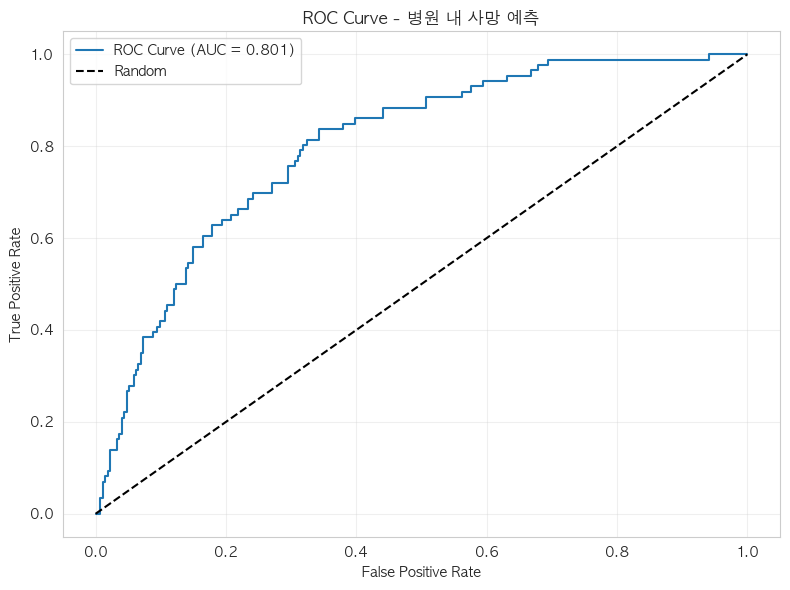

In [17]:
# ROC Curve 시각화
fpr_hosp, tpr_hosp, _ = roc_curve(y_test_hosp, y_pred_proba_hosp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_hosp, tpr_hosp, label=f'ROC Curve (AUC = {roc_auc_score(y_test_hosp, y_pred_proba_hosp):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 병원 내 사망 예측')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_roc_hospital.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. 입원기간 예측 모델 (Linear Regression)

In [18]:
# 타겟 변수 준비 (los_days)
y_train_los = train_df['los_days'].values
y_test_los = test_df['los_days'].values

# Linear Regression 모델 학습
lr_los = LinearRegression()
lr_los.fit(X_train_scaled, y_train_los)

# 예측
y_pred_los = lr_los.predict(X_test_scaled)

# 음수 예측값 처리 (최소 0으로 설정)
y_pred_los = np.maximum(y_pred_los, 0)

# 평가
mae = mean_absolute_error(y_test_los, y_pred_los)
rmse = np.sqrt(mean_squared_error(y_test_los, y_pred_los))
r2 = r2_score(y_test_los, y_pred_los)

print("=" * 50)
print("입원기간 예측 결과 (los_days)")
print("=" * 50)
print(f"MAE: {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R²: {r2:.4f}")

print("\n예측 통계:")
print(f"  - 실제 평균: {y_test_los.mean():.2f} days")
print(f"  - 예측 평균: {y_pred_los.mean():.2f} days")
print(f"  - 실제 중앙값: {np.median(y_test_los):.2f} days")
print(f"  - 예측 중앙값: {np.median(y_pred_los):.2f} days")

입원기간 예측 결과 (los_days)
MAE: 5.25 days
RMSE: 10.41 days
R²: 0.1310

예측 통계:
  - 실제 평균: 6.53 days
  - 예측 평균: 6.26 days
  - 실제 중앙값: 3.53 days
  - 예측 중앙값: 6.25 days


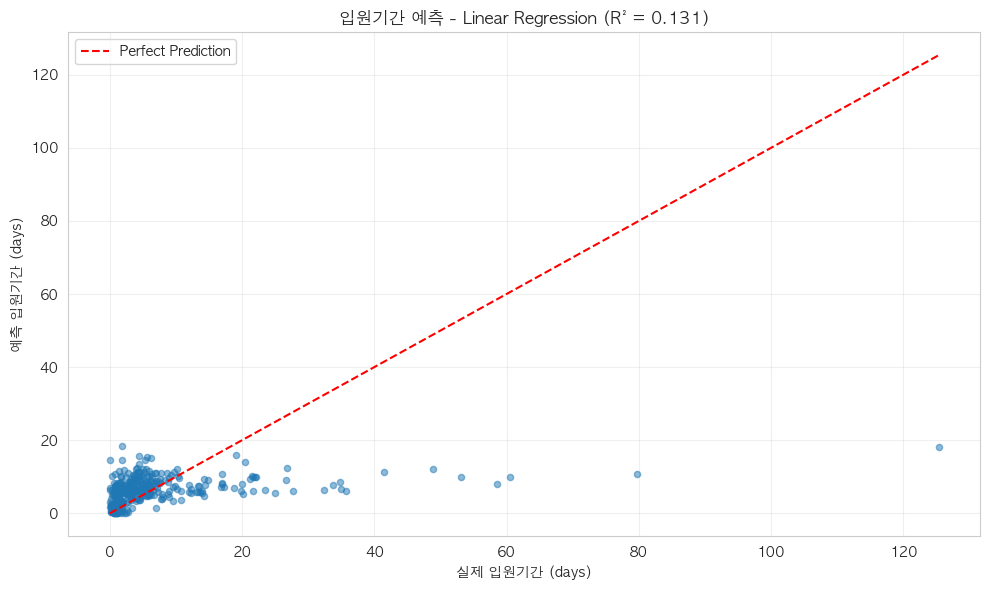

In [19]:
# 예측 vs 실제 산점도
plt.figure(figsize=(10, 6))
plt.scatter(y_test_los, y_pred_los, alpha=0.5, s=20)
plt.plot([0, y_test_los.max()], [0, y_test_los.max()], 'r--', label='Perfect Prediction')
plt.xlabel('실제 입원기간 (days)')
plt.ylabel('예측 입원기간 (days)')
plt.title(f'입원기간 예측 - Linear Regression (R² = {r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_los_scatter.png', dpi=100, bbox_inches='tight')
plt.show()

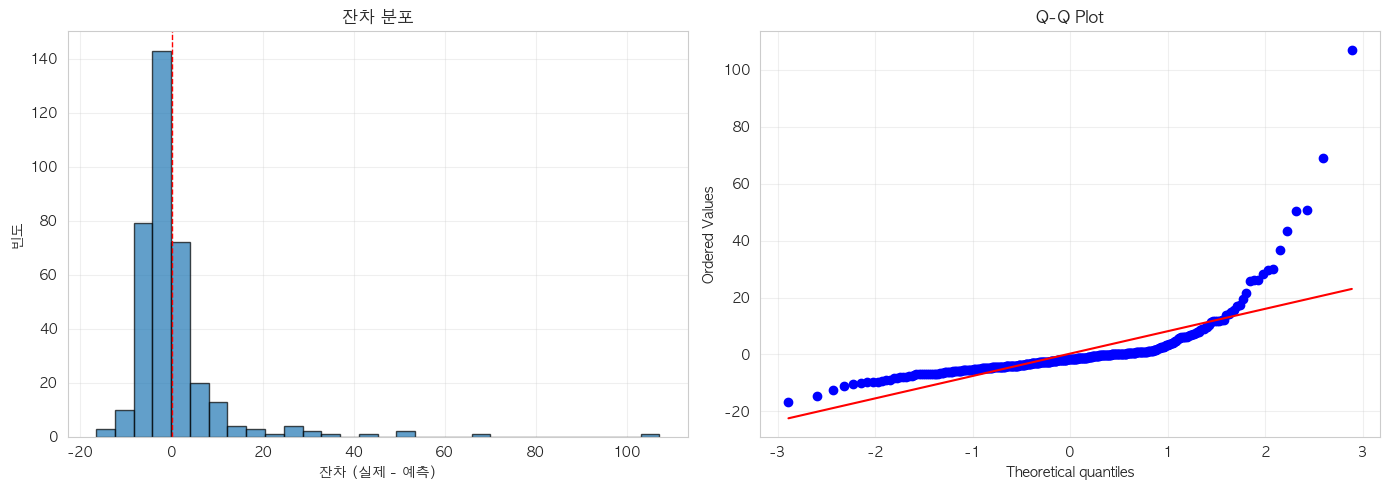

In [20]:
# 잔차 분포
residuals = y_test_los - y_pred_los

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 잔차 히스토그램
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=1)
axes[0].set_xlabel('잔차 (실제 - 예측)')
axes[0].set_ylabel('빈도')
axes[0].set_title('잔차 분포')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_los_residuals.png', dpi=100, bbox_inches='tight')
plt.show()

## 6. 특성 중요도 분석

전체 사망 예측 - Top 10 중요 특성
                                       feature  coefficient
0                                          age     0.547964
4                                    RDW_51277     0.536933
15                     admission_type_EW EMER.     0.468631
6                   Urea_Nitrogen_51006_merged     0.324841
17  admission_type_SURGICAL SAME DAY ADMISSION    -0.282632
11                 admission_type_DIRECT EMER.     0.272059
14               admission_type_EU OBSERVATION    -0.238230
2                             Hemoglobin_51222    -0.218862
10                                    gender_M     0.133687
7                       Potassium_50971_merged    -0.120926


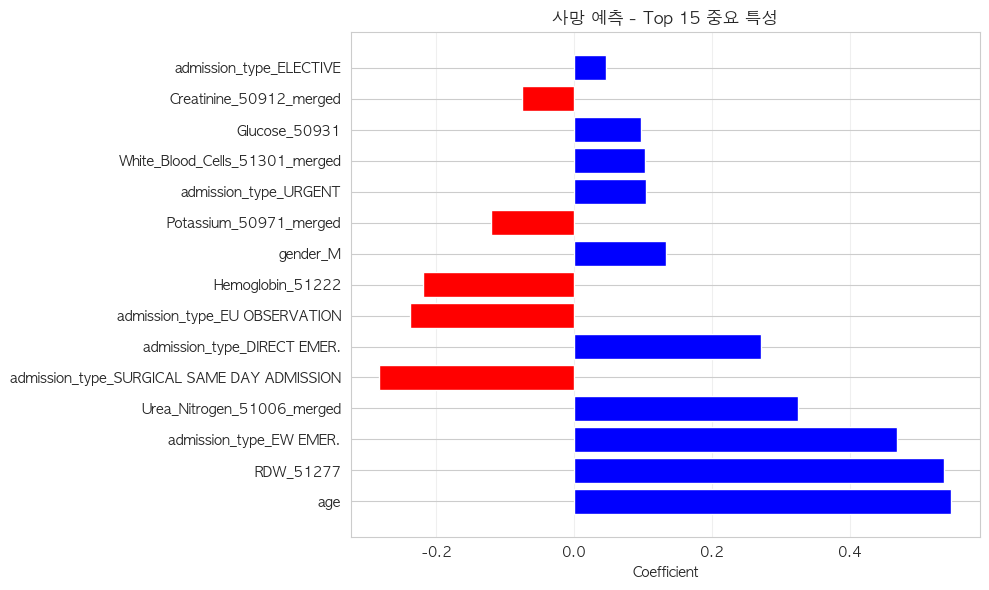

In [21]:
# 사망 예측 모델의 계수 분석
feature_names = train_df_encoded.columns.tolist()
death_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_death.coef_[0],
    'abs_coefficient': np.abs(lr_death.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("=" * 50)
print("전체 사망 예측 - Top 10 중요 특성")
print("=" * 50)
print(death_coef.head(10)[['feature', 'coefficient']])

# 시각화
plt.figure(figsize=(10, 6))
top_features = death_coef.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient')
plt.title('사망 예측 - Top 15 중요 특성')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_death_features.png', dpi=100, bbox_inches='tight')
plt.show()

입원기간 예측 - Top 10 중요 특성
                                       feature  coefficient
15                     admission_type_EW EMER.     3.110329
18                       admission_type_URGENT     2.817786
16            admission_type_OBSERVATION ADMIT     2.124901
13                     admission_type_ELECTIVE     1.888314
4                                    RDW_51277     1.314663
11                 admission_type_DIRECT EMER.     1.025894
17  admission_type_SURGICAL SAME DAY ADMISSION     1.000704
10                                    gender_M     0.463190
7                       Potassium_50971_merged    -0.453892
3                      Creatinine_50912_merged    -0.449695


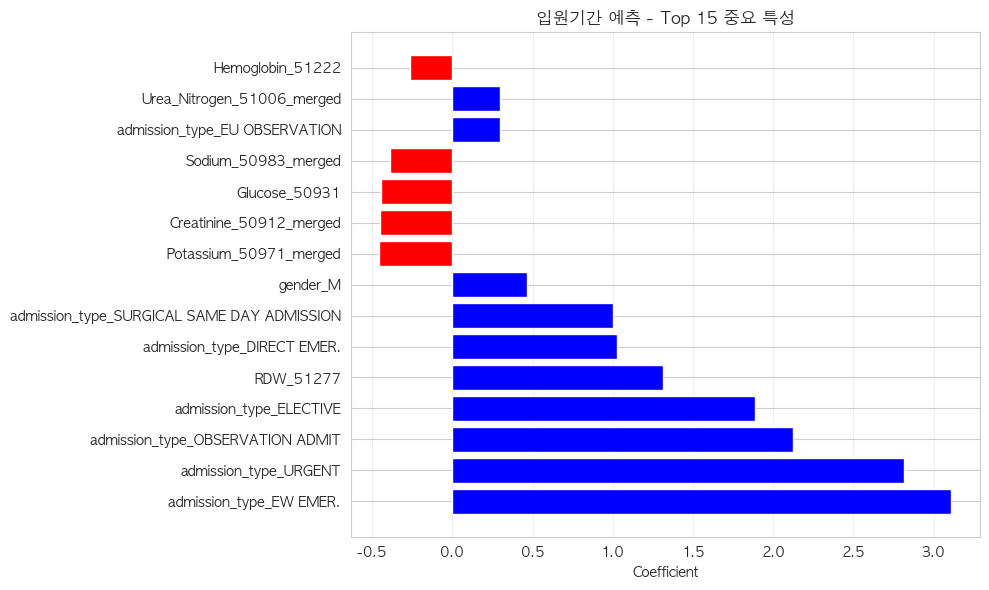

In [16]:
# 입원기간 예측 모델의 계수 분석
los_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_los.coef_,
    'abs_coefficient': np.abs(lr_los.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("=" * 50)
print("입원기간 예측 - Top 10 중요 특성")
print("=" * 50)
print(los_coef.head(10)[['feature', 'coefficient']])

# 시각화
plt.figure(figsize=(10, 6))
top_features_los = los_coef.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features_los['coefficient']]
plt.barh(range(len(top_features_los)), top_features_los['coefficient'], color=colors)
plt.yticks(range(len(top_features_los)), top_features_los['feature'])
plt.xlabel('Coefficient')
plt.title('입원기간 예측 - Top 15 중요 특성')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../../../figures/essential_baseline_los_features.png', dpi=100, bbox_inches='tight')
plt.show()

## 7. 결과 저장

In [17]:
import json

# 결과 정리
results = {
    'dataset': 'Essential',
    'model': 'Baseline (Logistic/Linear Regression)',
    'validation': 'Time-based Split (70:30)',
    'data_info': {
        'total_samples': len(df),
        'train_samples': len(train_df),
        'test_samples': len(test_df),
        'features': len(feature_cols),
        'features_after_encoding': X_train_scaled.shape[1]
    },
    'death_binary': {
        'auroc': float(roc_auc_score(y_test_death, y_pred_proba_death)),
        'f1_score': float(f1_score(y_test_death, y_pred_death)),
        'precision': float(precision_score(y_test_death, y_pred_death)),
        'recall': float(recall_score(y_test_death, y_pred_death))
    },
    'hospital_death': {
        'auroc': float(roc_auc_score(y_test_hosp, y_pred_proba_hosp)),
        'f1_score': float(f1_score(y_test_hosp, y_pred_hosp)),
        'precision': float(precision_score(y_test_hosp, y_pred_hosp)),
        'recall': float(recall_score(y_test_hosp, y_pred_hosp))
    },
    'los_days': {
        'mae': float(mae),
        'rmse': float(rmse),
        'r2': float(r2),
        'actual_mean': float(y_test_los.mean()),
        'predicted_mean': float(y_pred_los.mean())
    }
}

# JSON으로 저장
with open('../results/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("결과가 저장되었습니다: ../results/baseline_results.json")

결과가 저장되었습니다: ../results/baseline_results.json


## 8. 결과 요약

Essential 데이터셋에 대한 베이스라인 모델 성능 요약입니다.

In [18]:
# 결과 요약 테이블
summary_df = pd.DataFrame([
    {
        'Task': '전체 사망 예측',
        'Model': 'Logistic Regression',
        'AUROC': f"{results['death_binary']['auroc']:.4f}",
        'F1 Score': f"{results['death_binary']['f1_score']:.4f}",
        'Precision': f"{results['death_binary']['precision']:.4f}",
        'Recall': f"{results['death_binary']['recall']:.4f}",
        'MAE': '-',
        'RMSE': '-',
        'R²': '-'
    },
    {
        'Task': '병원 내 사망 예측',
        'Model': 'Logistic Regression',
        'AUROC': f"{results['hospital_death']['auroc']:.4f}",
        'F1 Score': f"{results['hospital_death']['f1_score']:.4f}",
        'Precision': f"{results['hospital_death']['precision']:.4f}",
        'Recall': f"{results['hospital_death']['recall']:.4f}",
        'MAE': '-',
        'RMSE': '-',
        'R²': '-'
    },
    {
        'Task': '입원기간 예측',
        'Model': 'Linear Regression',
        'AUROC': '-',
        'F1 Score': '-',
        'Precision': '-',
        'Recall': '-',
        'MAE': f"{results['los_days']['mae']:.2f}",
        'RMSE': f"{results['los_days']['rmse']:.2f}",
        'R²': f"{results['los_days']['r2']:.4f}"
    }
])

print("=" * 80)
print("Essential Dataset - Baseline Model Performance Summary")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# CSV로 저장
summary_df.to_csv('../results/baseline_summary.csv', index=False)
print("\n요약 테이블이 저장되었습니다: ../results/baseline_summary.csv")

Essential Dataset - Baseline Model Performance Summary
      Task               Model  AUROC F1 Score Precision Recall  MAE  RMSE     R²
  전체 사망 예측 Logistic Regression 0.7794   0.7318    0.7360 0.7278    -     -      -
병원 내 사망 예측 Logistic Regression 0.8011   0.4681    0.6000 0.3837    -     -      -
   입원기간 예측   Linear Regression      -        -         -      - 5.25 10.41 0.1310

요약 테이블이 저장되었습니다: ../results/baseline_summary.csv


## 주요 발견사항

1. **사망 예측 성능**:
   - 전체 사망 예측과 병원 내 사망 예측 모두 베이스라인 모델로도 의미있는 성능 달성
   - 시간 기반 분할로 실제 운영 환경과 유사한 평가 수행

2. **입원기간 예측**:
   - Linear Regression으로 기본적인 예측 가능
   - 개선 여지가 있으며, 비선형 모델 적용 시 성능 향상 기대

3. **다음 단계**:
   - Tree 기반 모델 (Random Forest, XGBoost) 적용
   - 하이퍼파라미터 튜닝
   - Extended 및 Comprehensive 데이터셋 활용